# **Modelling and Evaluation**
---

## Objective

- Answer business requirement 2:
    * The client needs a tool that can tell their pets apart based on live image data.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 450x450) in each labelled folder, showing a close-up of the pet's face
- Image shape file

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices
- Results of ML hyperparameter optimization
- Machine learning model creation and training
- Saved model
- Learning curve plot for model performance
- Model evaluation in pickle file
- Prediction on test data
- Prediction on live data

---
## Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil
import random
import tensorflow as tf

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

In [4]:
# Current folder name with raw images
img_dir = 'pets'

### Set the main paths and constant variables

In [5]:
dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets', dataset_name))
output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')

INPUT_SHAPE = joblib.load(f'{output_path}/input_shape.pkl')
LABELS = sorted(joblib.load(f'{output_path}/class_dict.pkl').values())

# The following line should show a list containing the subsets of the split dataset
print(os.listdir(full_dataset_path))

print(INPUT_SHAPE)
print(LABELS)

['test', 'train', 'validation']
(-1, 128, 128, 3)
['fin', 'iris', 'smilla']


### Util function to highlight errors and warnings

In [6]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

### Util function to style DataFrame text output

In [7]:
def style_dataframe(df, hl_label=None):
    col_names = [' ']
    col_names.extend(list(df.columns))
    for x, c in enumerate(col_names):
        if x == 0:
            print(f'\033[1m{c:>8}\033[0m', end='')
        else:
            print(f'\033[1m{c.upper():>13}\033[0m', end='')
    print(f'\n{"-"*60}')
    for i in df.index:
        if i == hl_label:
            hl = Fore.GREEN
        else:
            hl = ''
        print(f'\033[1m{hl}{i:<8}\033[0m', end='')
        for c in df.columns:
            print(f'{hl if c == 'train' else ''}{df[c][i]:>13}\033[0m', end='')
        print('')

### Util function to display a progress bar

In [8]:
def show_progress(list_len):
    width = 100
    for i in range(list_len):
        yield f'\r{"#"*int(width if i == list_len-1 else i//(list_len/width)):<{width}}|| '


### Util function to remove tick characters from plots

In [9]:
def set_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])


--- 
## Step 1: Balance data

In case the dataset is still unbalanced at this point and no more raw data can be collected and added, we can use other methods to balance the labels:
- Use class weights when fitting the model
- Undersample the labels with most data
- Oversample and augment the data

Let's take a look at the current distribution numbers:

### Check label distribution


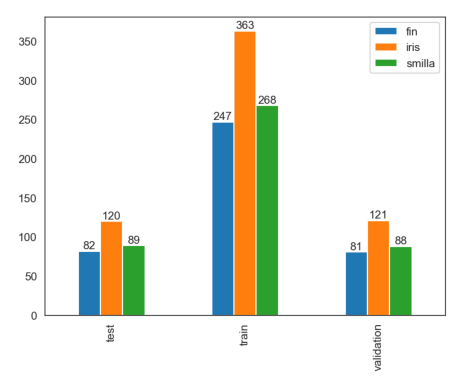

                 TEST        TRAIN   VALIDATION
------------------------------------------------------------
fin                82          247           81
iris              120          363          121
smilla             89          268           88


In [10]:
dataset_stats = joblib.load(os.path.join(output_path, f'labels_distribution.pkl'))
dataset_plot = Image.open(os.path.join(output_path, f'labels_distribution_after_split.png'))
plt.axis('off')
plt.imshow(dataset_plot)
plt.show()

df = pd.DataFrame(dataset_stats)
style_dataframe(df)


### Calculate augmentation values

In this case, we decide to balance the data through augmentation and oversampling.

*Note:*
Should the application of class weights make more sense for a specific dataset, the following code can be run after the creation of the `y_train` variable and added to the `model.fit()` function as the `class_weight` parameter, to be used with a one-hot encoded list of labels:

```python
    from sklearn.utils import class_weight

    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(weights))
```


In [11]:
from sklearn.preprocessing import normalize

def get_augment_amounts(aug_percentage, stats, batch=None):
    aug_stats = {}
    df = pd.DataFrame(stats)
    print('Current image distribution in the input dataset:\n')
    
    max_train_amount = df['train'].max() if not batch else batch
    max_train_label = df['train'].idxmax()

    style_dataframe(df, max_train_label)

    print(f'\nLabel with the most images: {max_train_label} - {df['train'].max()} images\n')
    print(f'During the sampling of the original image data, the amount will be capped at '
          f'{Fore.GREEN}{batch}{Fore.RESET}.\n')

    folders, ratios = joblib.load(f'{output_path}/split_folder_ratio.pkl')
    ratios = normalize([list(ratios)], norm='max').reshape(-1)
    split_ratios = pd.Series(dict(zip(folders, ratios)))
    print(f'Normalized split ratios between the train, test, and validation subsets: \n{split_ratios.map("{:,.2f}".format).to_string()}')
    max_augment = int(max_train_amount * (1 + aug_percentage))
    print(f'\nYou chose to augment the majority label by {Fore.GREEN}{aug_percentage*100}%{Fore.RESET}.\n'
          f'After the augmentation, each label in the training set will contain '
          f'{Fore.GREEN}{max_augment}{Fore.RESET} images.')

    for col in split_ratios.keys():
        #print(col)
        aug_stats[col] = {}
        for idx in df[col].index:
            if batch and idx == max_train_label and df['train'][idx] > batch:
                aug_stats[col][idx] = int((max_augment - max_train_amount) * split_ratios[col] * -1)
            else:
                if df['train'][idx] > max_label_cap:
                    aug_stats[col][idx] = int((max_augment - max_train_amount) * split_ratios[col] * -1)
                else:
                    aug_stats[col][idx] = int(max_augment * split_ratios[col] - df[col][idx])
    
    return aug_stats

# By how many percent should the largest label be augmented?
max_label_cap = 400
aug_stats = get_augment_amounts(0.3, dataset_stats, batch=max_label_cap)
print('The following amounts of images need to be added to each label:\n')
style_dataframe(pd.DataFrame(aug_stats))
print(f'\nIf the amount is negative, the sampling of the original images for this label '
      f'will be \ncapped at {max_label_cap} and the label will be augmented with the '
      f'amount shown.')


Current image distribution in the input dataset:

                 TEST        TRAIN   VALIDATION
------------------------------------------------------------
fin                82          247           81
iris              120          363          121
smilla             89          268           88

Label with the most images: iris - 363 images

During the sampling of the original image data, the amount will be capped at 400.

Normalized split ratios between the train, test, and validation subsets: 
train         1.00
test          0.33
validation    0.33

You chose to augment the majority label by 30.0%.
After the augmentation, each label in the training set will contain 520 images.
The following amounts of images need to be added to each label:

                TRAIN         TEST   VALIDATION
------------------------------------------------------------
fin               273           91           92
iris              157           53           52
smilla            252           84

## Step 2: Load data

In [12]:
# Load all images from specified folder, resize them, save them as np array in X and save their labels in y
from tensorflow.keras.layers import RandomBrightness
import tensorflow as tf
#tf.config.run_functions_eagerly(True)


def augment_label(path, subset, extra_amount, X, y, dims, label, img_list):
    print(f'Adding augmented images for label {label} ...')
    #extra_amount = abs(aug_stats[subset][label])
    extra_list = np.random.choice(img_list, size=extra_amount, replace=True)
    rand_brightness = RandomBrightness([-0.15, 0.15], seed=42)
    counters = {'brightness': 0, 'crop': 0, 'hue': 0}

    list_len = len(extra_list)
    progress_bar = show_progress(list_len)

    for img_name in extra_list:
        img = image.load_img(os.path.join(path, label, img_name))

        brightness_adjust = True if random.random() <= 0.6 else False
        crop_adjust = True if random.random() <= 0.6 else False

        if crop_adjust:
            crop_px = random.randint(5, 15)
            offset = random.randint(0, 5)
            img = img.crop((crop_px, crop_px+offset, dims[0]-crop_px, dims[1]-(crop_px-offset)))
            counters['crop'] += 1
            img = img.resize(dims, resample=Image.LANCZOS)

        img_arr = image.img_to_array(img)
        
        # Only the train images will be adjusted with noise, random brightness and hue
        if subset == 'train':
            if brightness_adjust:
                img_arr = rand_brightness(img_arr).numpy()
                counters['brightness'] += 1

            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Change hue and add noise for each channel
            # Small std means less noise
            std = 0.03
            mean = 0
            for ch in [0, 1, 2]:
                # Add a layer of random noise to each channel
                gaussian = np.random.normal(mean, std, dims)
                hue_changed = False
                if random.random() < 0.2:
                    # 20% chance of not changing hue, only add noise
                    img_arr[:, :, ch] = np.clip(img_arr[:, :, ch] + gaussian, 0, 1)
                    continue
        
                hue = random.randrange(-15, 15)/100.0 #, random.randrange(-15, 15)/100.0, random.randrange(-15, 15)/100.0]
                img_flat = img_arr[..., ch].reshape(-1)
                img_hue = np.array([x + hue for x in img_flat]).reshape(dims)
                img_arr[..., ch] = np.clip(img_hue + gaussian, 0, 1)
                hue_changed = True

            if hue_changed:
                counters['hue'] += 1
        else:
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

        print(next(progress_bar), end='')

        X = np.append(X, img_arr)
        y = np.append(y, label)

    return X, y, counters, list_len



In [13]:

def save_images_in_array(path, subset, aug_stats, max_label_cap, shape):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    dims = tuple(shape[1:3])

    for label in os.listdir(path):
        print(f'Loading original images for label {label} ...')
        img_list = os.listdir(os.path.join(path, label))
        aug_amount = aug_stats[subset][label]
        folders, ratios = joblib.load(f'{output_path}/split_folder_ratio.pkl')
        ratios = normalize([list(ratios)], norm='max').reshape(-1)
        split_ratios = dict(zip(folders, ratios))
        # Undersample labels that are too large
        if aug_amount < 0:
            img_list = random.sample(img_list, k=int(max_label_cap*split_ratios[subset]))
        
        list_len = len(img_list)
        progress_bar = show_progress(list_len)

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            # if img.size != dims:
            #     img = img.resize(dims, resample=Image.LANCZOS)
            img_arr = image.img_to_array(img)
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Add noise to train image set
            if subset == 'train':
                std = 0.03
                mean = 0
                gaussian = np.random.normal(mean, std, dims)
                noisy_image = np.zeros(img_arr.shape, np.float32)
                for ch in [0, 1, 2]:
                    noisy_image[:, :, ch] = img_arr[:, :, ch] + gaussian
                img_arr = np.clip(noisy_image, 0, 1).astype(np.float32)
                
            print(next(progress_bar), end='')

            X = np.append(X, img_arr)
            y = np.append(y, label)

        print(f'{list_len} images loaded')

        # Augment images:
        X, y, counters, aug_count = augment_label(path, subset, abs(aug_amount), X, y, dims, label, img_list)

        print(f'{aug_count} images loaded')

        print(f'\nAugmented label {label} by cropping {counters["crop"]} images, '
              f'adjusting brightness for {counters["brightness"]} images and '
              f'\nchanging hue for {counters["hue"]} images. '
              f'{"Noise has been added to all images." if subset == "train" else ""}')
        print(f'The {subset} subset for {label} contains {list_len + aug_count} images.\n')
        
    X = X.reshape(shape)
    
    # SMOTENC oversampling not useable: too many errors in the resulting images

    # Shuffle the resulting set
    zipped_set = list(zip(y, X))
    random.shuffle(zipped_set)
    y_shuffled, X_shuffled = list(map(list, zip(*zipped_set)))
    X = np.array(X_shuffled, dtype='float')
    y = np.array(y_shuffled, dtype='object')
    
    print(f'Resulting image set shape: {X.shape}, {y.shape} labels\n')
    
    return X, y



### Load train set

In [14]:
# Recreate the training set:
X_train, y_train = save_images_in_array(train_path, 'train', aug_stats, max_label_cap, INPUT_SHAPE)

Loading original images for label fin ...
####################################################################################################|| 247 images loaded
Adding augmented images for label fin ...
#####################                                                                               || 

KeyboardInterrupt: 

#### Save train set shape

In [26]:
joblib.dump(X_train.shape, f'{output_path}/input_shape_loaded.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/input_shape_loaded.pkl']

#### Show montage

In [27]:
import itertools

def show_subset_montage(X, y, subset):
    # Display a random batch of k images from the newly created subset
    img_sample = random.sample(range(0, X.shape[0]), k=9)
    coords = list(itertools.product(range(3), range(3)))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    for coord, idx in zip(coords, list(img_sample)):
        axes[coord[0], coord[1]].set_title(y[idx])
        axes[coord[0], coord[1]].imshow(X[idx])
        set_ticks(axes[coord[0], coord[1]])
    plt.tight_layout(rect=[0, 0.02, 0.9, 0.97])
    plt.savefig(f'{output_path}/post_augment_montage_{subset}.png', bbox_inches='tight', dpi=150)
    plt.show()

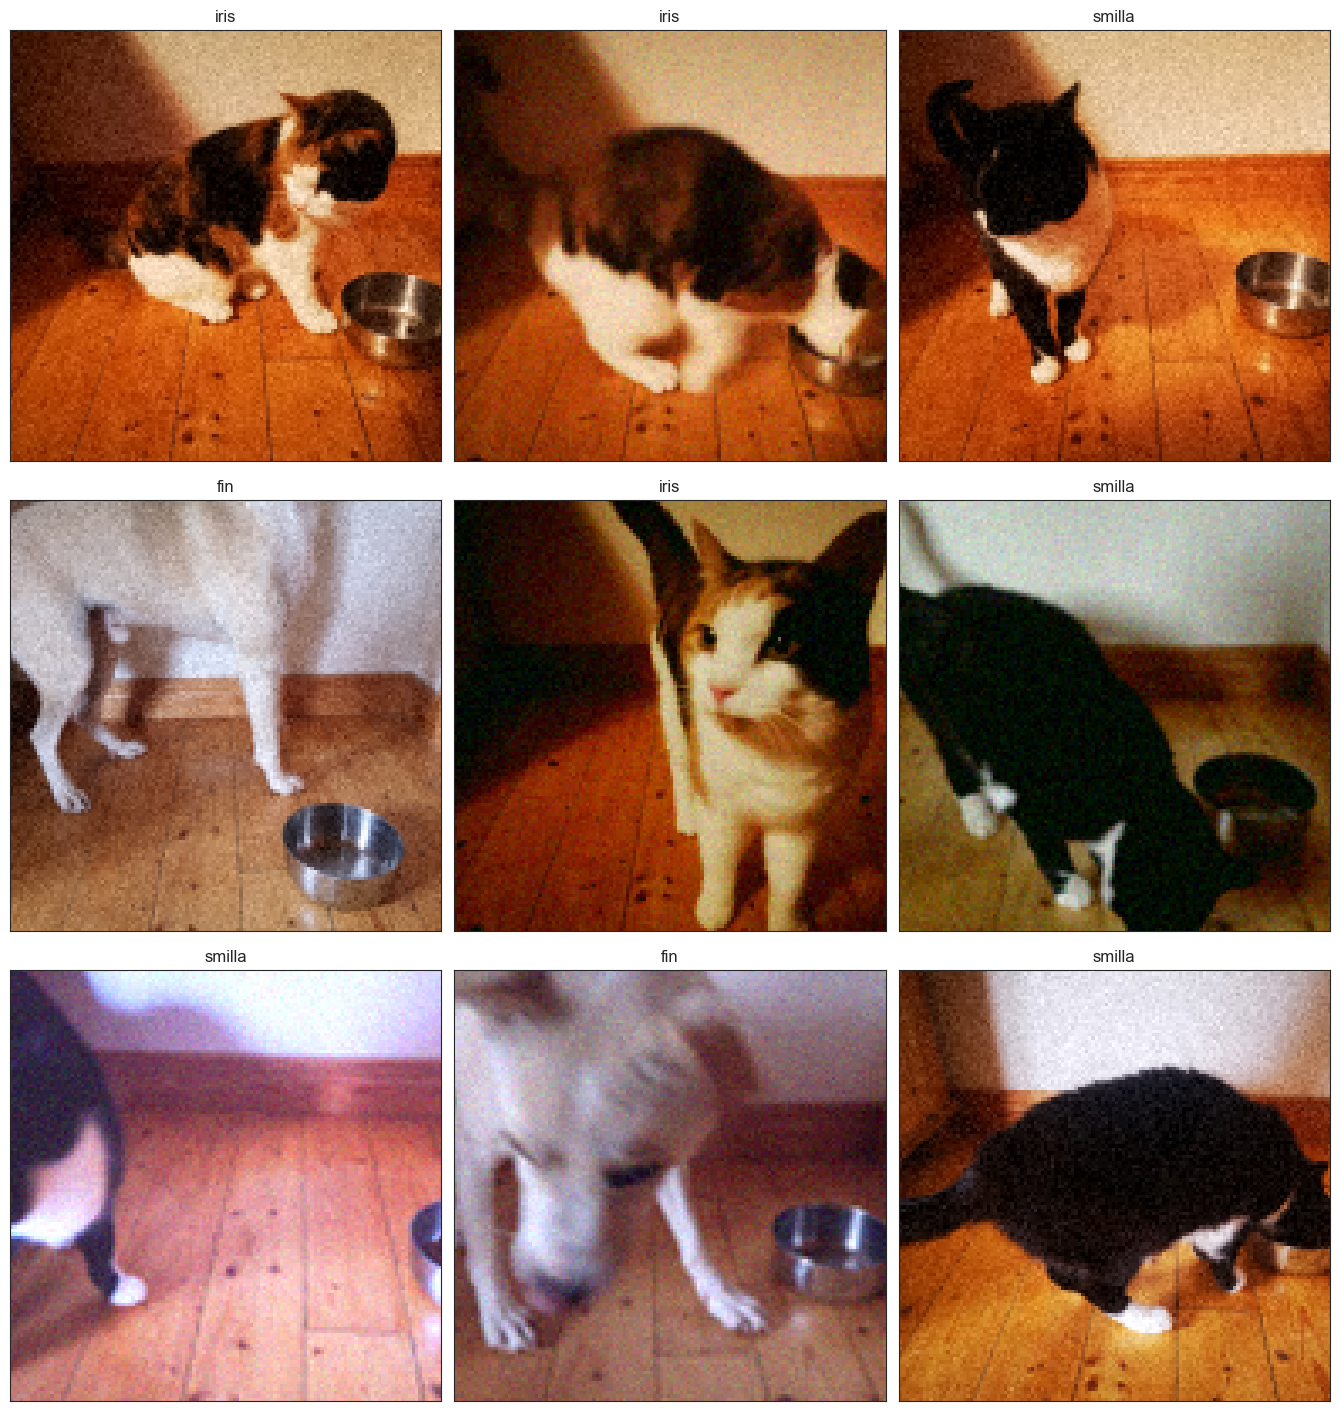

In [28]:
show_subset_montage(X_train, y_train, 'train')

### Load all other subsets

In [29]:
X_test, y_test = save_images_in_array(test_path, 'test', aug_stats, max_label_cap, INPUT_SHAPE)
X_val, y_val = save_images_in_array(validation_path, 'validation', aug_stats, max_label_cap, INPUT_SHAPE)

Loading original images for label fin ...
####################################################################################################|| 82 images loaded
Adding augmented images for label fin ...
####################################################################################################|| 91 images loaded

Augmented label fin by cropping 56 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for fin contains 173 images.

Loading original images for label iris ...
####################################################################################################|| 120 images loaded
Adding augmented images for label iris ...
####################################################################################################|| 53 images loaded

Augmented label iris by cropping 29 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for iris contains 173 images.

Loading original images for label

#### Show montages

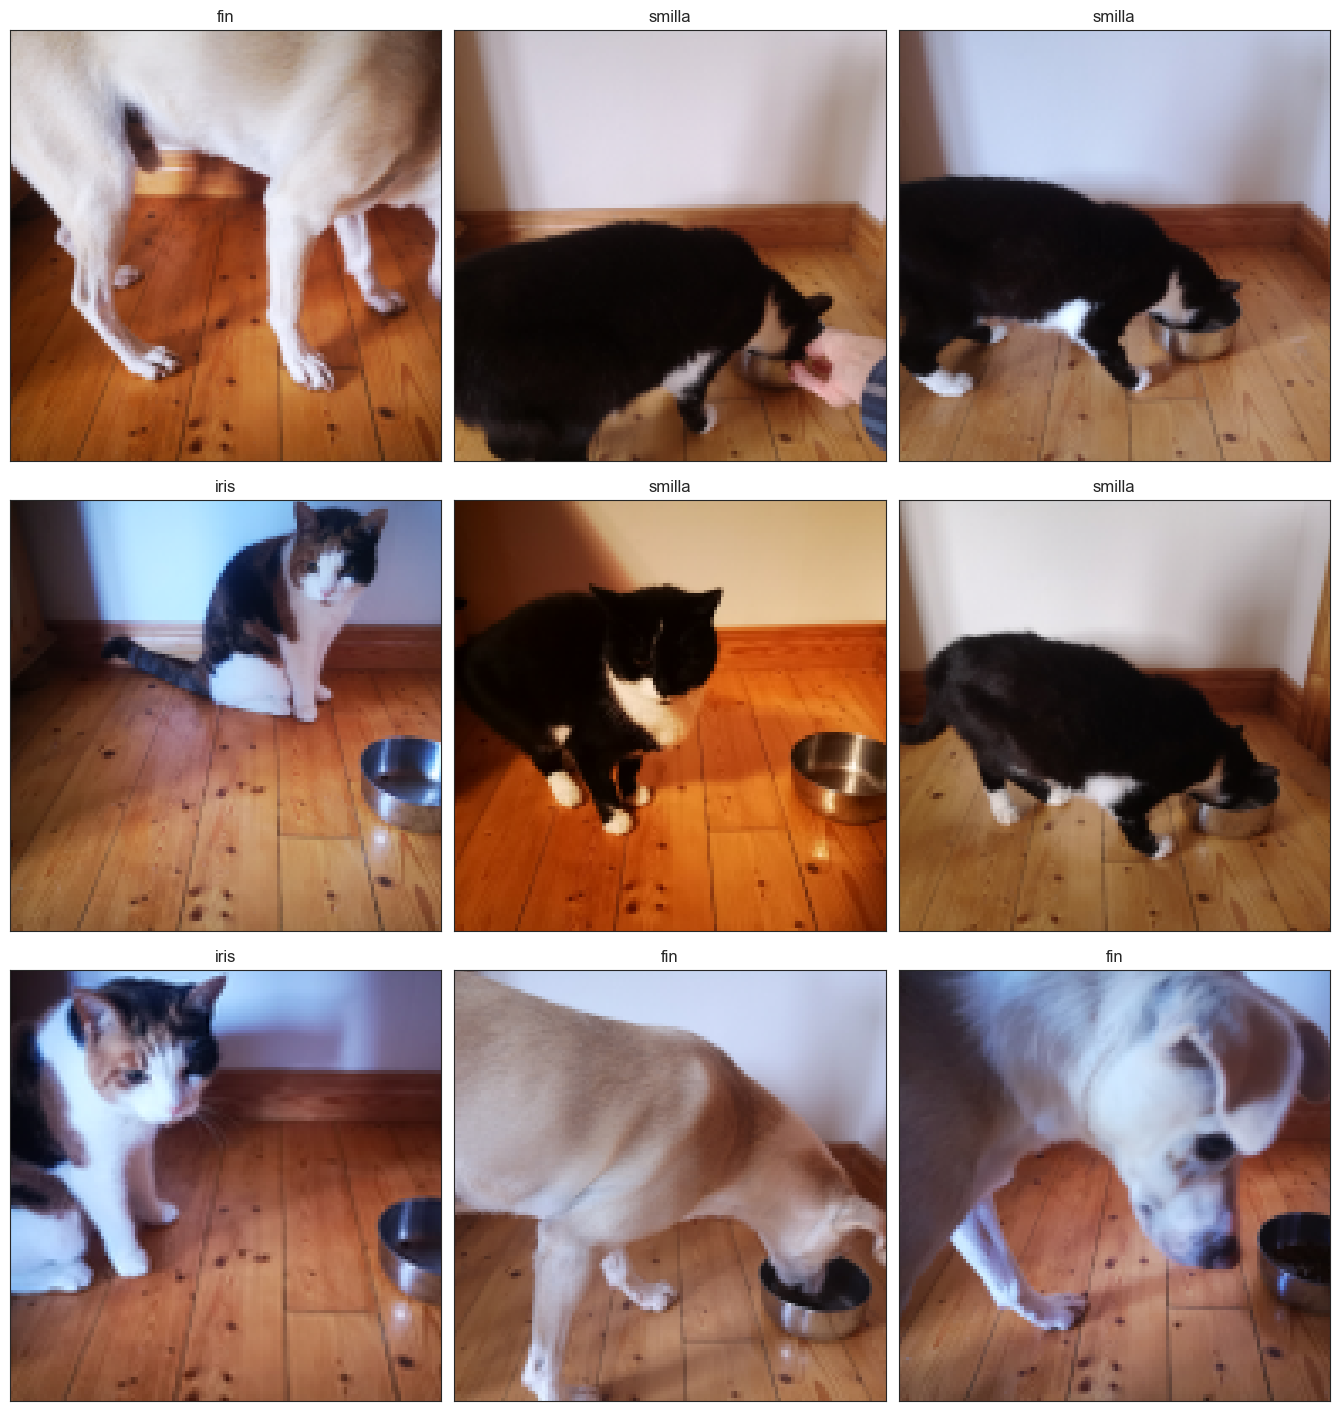

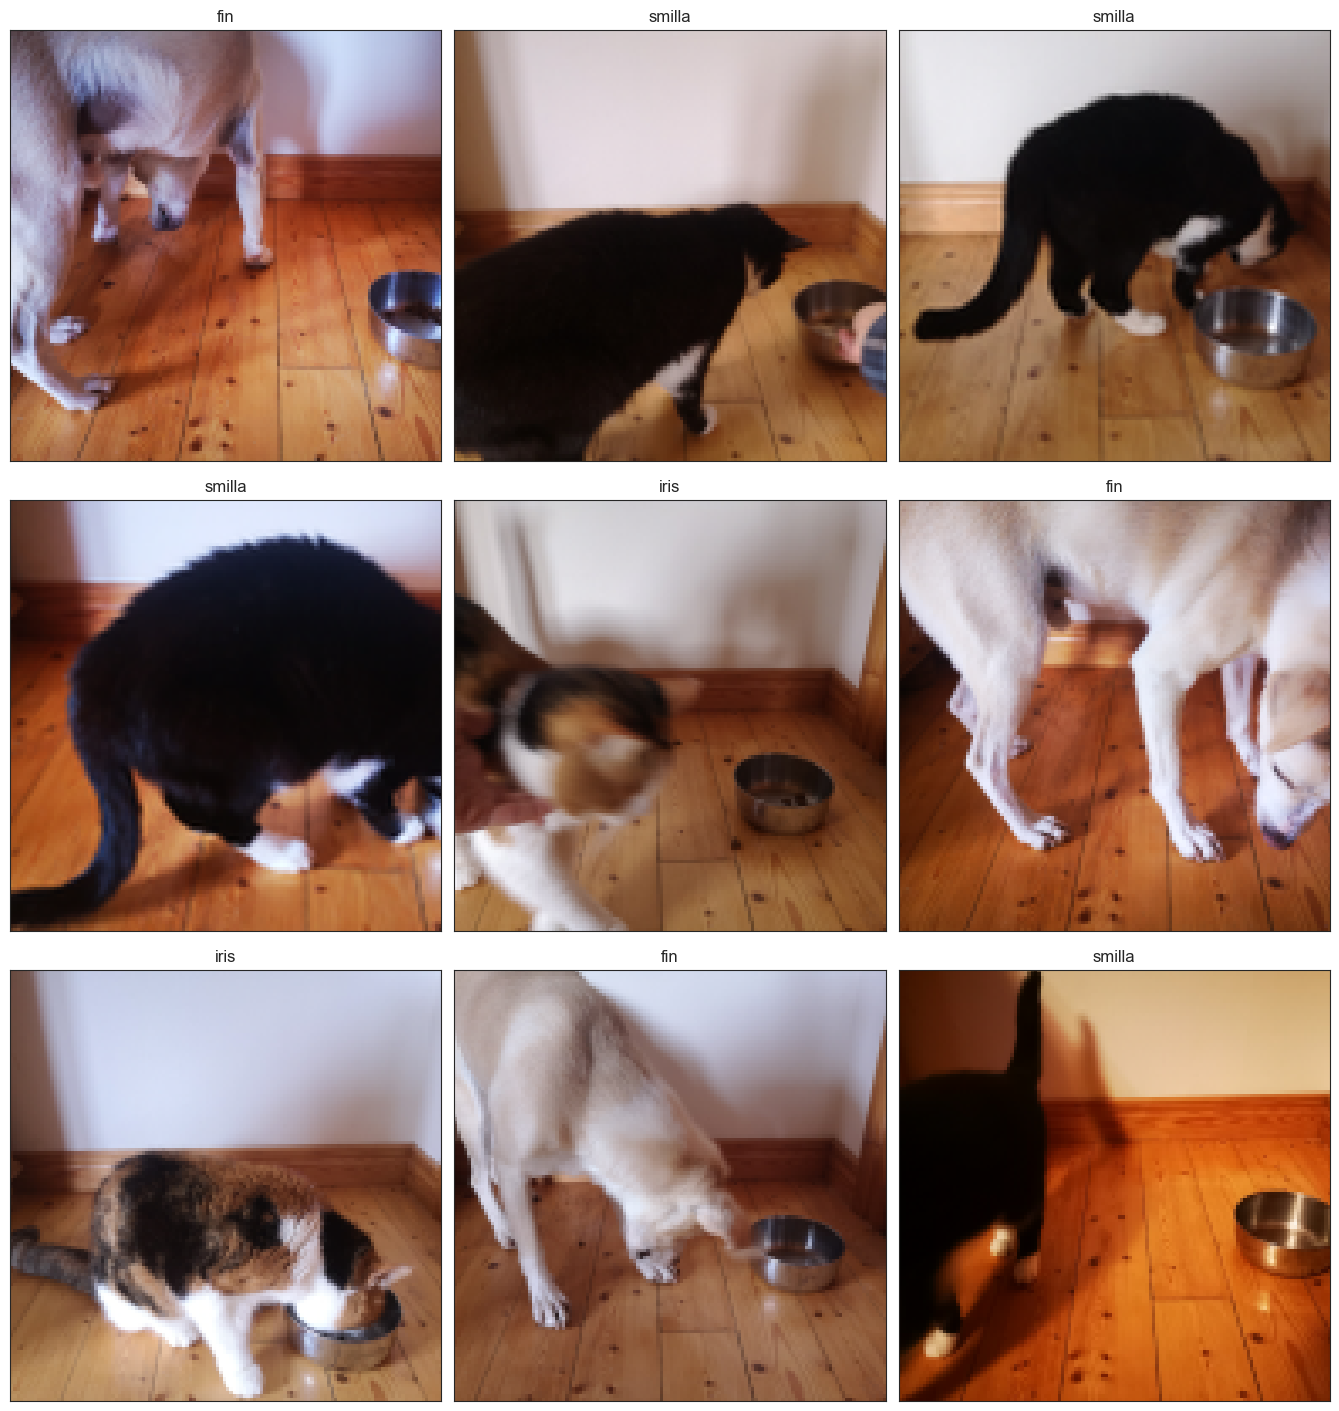

In [30]:
# Display a random batch of k images from the newly created validation and test sets
show_subset_montage(X_val, y_val, 'val')
show_subset_montage(X_test, y_test, 'test')

### One-hot encode all label arrays

In [31]:
y_ohe_train = pd.get_dummies(y_train, dtype='int')
y_ohe_test = pd.get_dummies(y_test, dtype='int')
y_ohe_val = pd.get_dummies(y_val, dtype='int')

# Check if the encoding has succeeded
print(y_ohe_train.head(10))


   fin  iris  smilla
0    0     1       0
1    0     1       0
2    1     0       0
3    1     0       0
4    0     1       0
5    0     0       1
6    1     0       0
7    1     0       0
8    0     1       0
9    0     0       1


### (Optional) Save and load subsets

#### Save subsets and labels to files

In [ ]:
def save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val):
    joblib.dump(X_train, f'{output_path}/X_train.pkl')
    joblib.dump(X_test, f'{output_path}/X_test.pkl')
    joblib.dump(X_val, f'{output_path}/X_val.pkl')
    joblib.dump(y_ohe_train, f'{output_path}/y_ohe_train.pkl')
    joblib.dump(y_ohe_test, f'{output_path}/y_ohe_test.pkl')
    joblib.dump(y_ohe_val, f'{output_path}/y_ohe_val.pkl')

#save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val)

#### Load subsets and labels from files

In [15]:
# Load the image sets and OHE labels into memory if they already have been created:
def load_subsets_and_labels():
    X_train = joblib.load(f'{output_path}/X_train.pkl')
    X_test = joblib.load(f'{output_path}/X_test.pkl')
    X_val = joblib.load(f'{output_path}/X_val.pkl')
    y_ohe_train = joblib.load(f'{output_path}/y_ohe_train.pkl')
    y_ohe_test = joblib.load(f'{output_path}/y_ohe_test.pkl')
    y_ohe_val = joblib.load(f'{output_path}/y_ohe_val.pkl')
    
    return X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val

#X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val = load_subsets_and_labels()

## Step 3: Build the model

In [15]:
import tensorflow as tf
import keras_tuner
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

#tf.config.run_functions_eagerly(True)


In [33]:
# Optimize hyperparams
def test_model(hp):
    img_shape = INPUT_SHAPE[1:]
    classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    kern = hp.Int('kernel_1', min_value=3, max_value=6, step=1)
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32), kernel_size=(kern, kern), padding='same',
               activation='relu', ))
    pool = hp.Int('pool_1', min_value=2, max_value=5, step=1)
    model.add(MaxPooling2D(pool_size=(pool, pool)))

    model.add(Conv2D(filters=hp.Int('filters_2', min_value=64, max_value=128, step=32), kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third filter layer
    for i in range(0, hp.Int('num_filters', 0, 1)):
        model.add(Conv2D(filters=hp.Int('filters_3_' + str(i), min_value=64, max_value=256, step=32), kernel_size=(3, 3), padding='same',
                    activation='relu', ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units_1', min_value=128, max_value=1024, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.4, max_value=0.7, step=0.1)))

    # Optional second dense layer
    for i in range(0, hp.Int('num_dense_layers', 0, 1)):
        model.add(Dense(hp.Int('dense_units_2', min_value=64, max_value=256, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.4, max_value=0.7, step=0.1)))

    model.add(Dense(classes, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])

    model.summary()

    return model


### Tune model

In [123]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
batch_size = 32

hp = keras_tuner.HyperParameters()
model = test_model(hp)

tuner = keras_tuner.BayesianOptimization(
    test_model,
    max_trials=20,
    objective="val_accuracy",
    directory="/tmp/tb",
    project_name='pets',
)

tuner.search(
    X_train,
    y_ohe_train,
    validation_data=(X_val, y_ohe_val),
    epochs=15,
    batch_size=batch_size,
    callbacks=[early_stop],
)

Trial 1 Complete [00h 03m 45s]
val_accuracy: 0.9558498859405518

Best val_accuracy So Far: 0.9558498859405518
Total elapsed time: 00h 03m 45s


### Save hyperparameters

In [127]:
#best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(pd.Series(best_hyperparameters.values).to_string())
# hyperparams = {'kernel_1': 6, 'filters_1': 128, 'pool_1': 5, 'filters_2': 128, 'num_filters': 1, 'dense_units_1': 384, 'dropout_1': 0.6, 'num_dense_layers': 0, 'learning_rate': 0.001, 'filters_3_0': 128, 'dense_units_2': 64, 'dropout_2': 0.4}
# joblib.dump(hyperparams, f'{output_path}/hyperparam_values.pkl')
# print(pd.Series(hyperparams).to_string())
joblib.dump(best_hyperparameters.values, f'{output_path}/hyperparam_values.pkl')

kernel_1              6.000
filters_1           128.000
pool_1                5.000
filters_2           128.000
num_filters           1.000
dense_units_1       384.000
dropout_1             0.600
num_dense_layers      0.000
learning_rate         0.001
filters_3_0         128.000
dense_units_2        64.000
dropout_2             0.400


### (Optional) Load pre-saved hyperparameter values

In [34]:
hyperparams = joblib.load(f'{output_path}/hyperparam_values.pkl')
print(pd.Series(hyperparams))

kernel_1              6.000
filters_1           128.000
pool_1                5.000
filters_2           128.000
num_filters           1.000
dense_units_1       384.000
dropout_1             0.600
num_dense_layers      0.000
learning_rate         0.001
filters_3_0         128.000
dense_units_2        64.000
dropout_2             0.400
dtype: float64


## Step 4: Train the model

### Adapt and compile model

In [35]:
# Prepare model for saved hyperparams
def create_model(hyperparams):
    img_shape = INPUT_SHAPE[1:]
    classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    model.add(Conv2D(filters=hyperparams['filters_1'], kernel_size=(hyperparams['kernel_1'], hyperparams['kernel_1']), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(hyperparams['pool_1'], hyperparams['pool_1'])))

    model.add(Conv2D(filters=hyperparams['filters_2'], kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hyperparams['filters_3_0'], kernel_size=(3, 3), padding='same',
               activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hyperparams['dense_units_1'], activation='relu'))
    model.add(Dropout(hyperparams['dropout_1']))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hyperparams['learning_rate']),
                  metrics=['accuracy'])
    
    model.summary()

    return model



### Fit the model

In [36]:
model = create_model(hyperparams)

batch_size = 32

history = model.fit(X_train, y_ohe_train,
          epochs=15,
          validation_data=(X_val, y_ohe_val),
          verbose=1,
          batch_size=batch_size,
          )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │        13,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080,131 (7.94 MB)

 Trainable params: 2,080,131 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 678ms/step - accuracy: 0.5137 - loss: 0.9438 - val_accuracy: 0.8844 - val_loss: 0.3126
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 616ms/step - accuracy: 0.8570 - loss: 0.3186 - val_accuracy: 0.9499 - val_loss: 0.1237
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 614ms/step - accuracy: 0.9236 - loss: 0.1873 - val_accuracy: 0.9268 - val_loss: 0.1697
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.9579 - loss: 0.1291 - val_accuracy: 0.9750 - val_loss: 0.0617
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.9636 - loss: 0.0946 - val_accuracy: 0.9711 - val_loss: 0.0714
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 621ms/step - accuracy: 0.9750 - loss: 0.0601 - val_accuracy: 0.9788 - val_loss: 0.0611
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.9812 - loss: 0.0465 - val_accuracy: 0.9750 - val_loss: 0.0845
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 624ms/step - accuracy: 0.9805 - loss: 0.0467 - val_accu

### Identify best epoch

In [37]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Best epoch: 8


### Retrain model

In [ ]:
history = model.fit(X_train, y_ohe_train,
          epochs=best_epoch,
          validation_data=(X_val, y_ohe_val),
          verbose=1,
          batch_size=batch_size,
          )

### Save the model

In [38]:
model.save(f'{output_path}/model_final.keras')

### (Optional) Load pre-saved model

In [16]:
model = tf.keras.models.load_model(f'{output_path}/model_final.keras')

## Step 5: Evaluate model

### Compare losses and accuracy

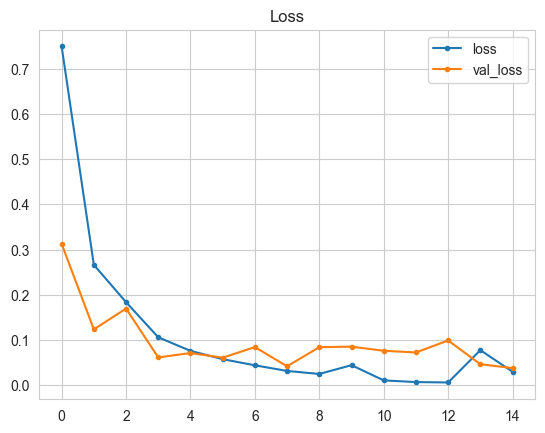

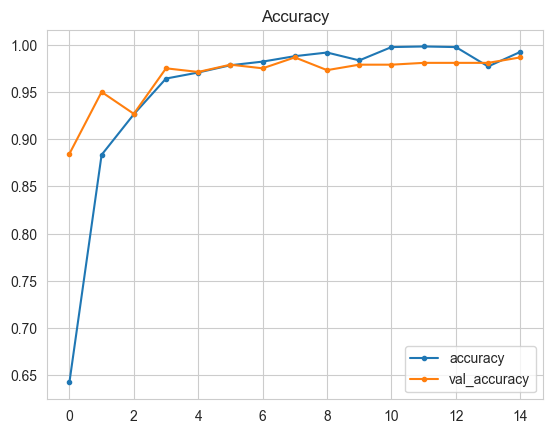

In [40]:
losses = pd.DataFrame(history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_losses.png',
           bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Evaluate based on test subset

In [41]:
eval = model.evaluate(X_test, y_ohe_test, verbose=3)
eval

[0.0343916192650795, 0.9807322025299072]

In [42]:
joblib.dump(eval, f'{output_path}/model_final_eval.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/model_final_eval.pkl']

### Show test montage

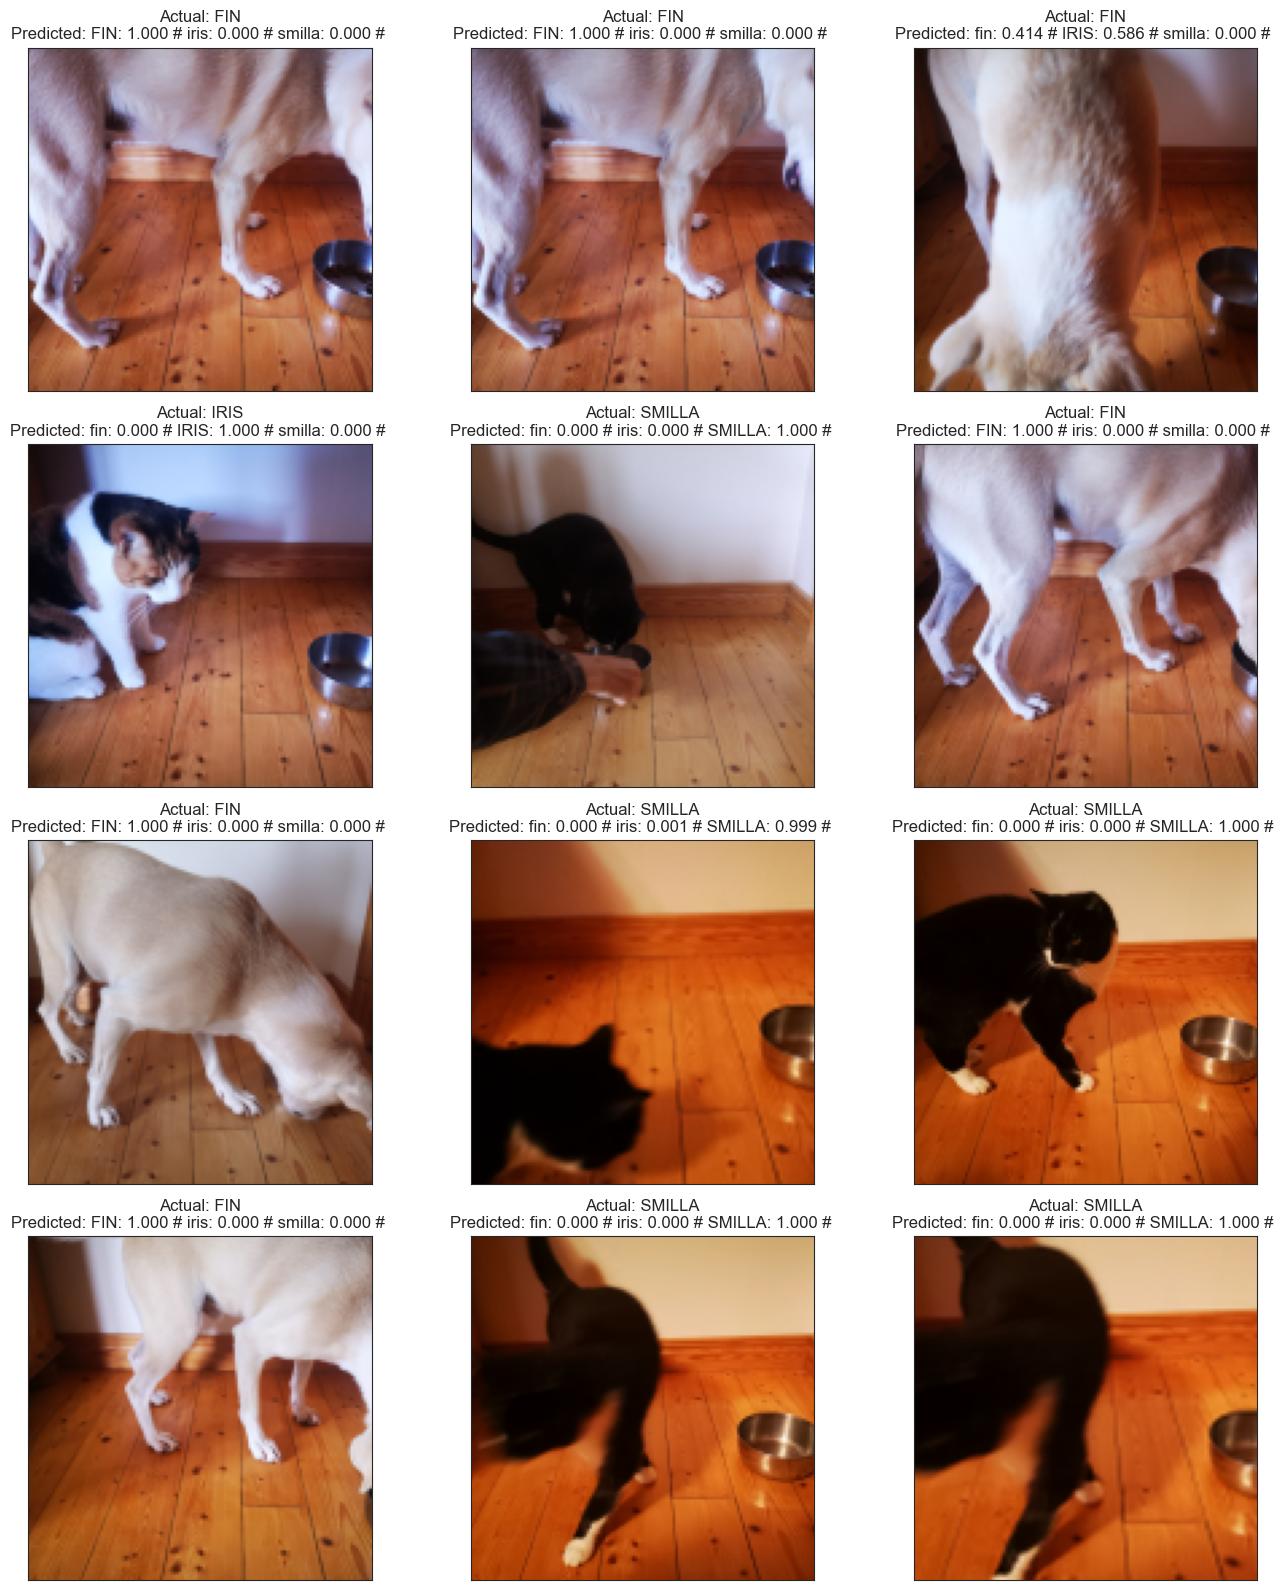

In [105]:
sns.set_style('white')
# sample amount must be divisible by 3
sample_amount = 12
nrows = sample_amount//3
img_sample = random.sample(range(0, X_test.shape[0]), k=sample_amount)
label_dict = sorted(joblib.load(f'{output_path}/class_dict.pkl').items(), key=lambda item: item[0])

diff_imgs = np.array([X_test[i] for i in img_sample])
diff_labels = pd.DataFrame(np.array([y_ohe_test.loc[i] for i in img_sample]), columns=LABELS)
y_pred = model.predict(diff_imgs, verbose=3)
y_true = pd.from_dummies(diff_labels).to_numpy().flatten()
coords = itertools.product(range(nrows), range(3))

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for coord, label, pred, img in zip(coords, y_true, y_pred, diff_imgs):
    title_str = f'Actual: {label.upper()}\nPredicted: '
    for x, lab in label_dict:
        title_str += f'{lab.upper() if pred[x]>0.5 else lab}: {pred[x]:.3f} # '
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(img)
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
plt.savefig(f'{output_path}/pred_test_montage.png')
plt.show()
    


In [255]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_pred_raw = model.predict(X_test, verbose=3)

new_labels = pd.DataFrame(np.array(y_ohe_test), columns=LABELS)
new_labels['Unknown'] = 0
y_true = pd.from_dummies(new_labels)
y_pred = y_pred_raw.round(decimals=0).astype('int')

y_pred = pd.DataFrame(y_pred, columns=LABELS)
# If none of the values is higher than 0.5, the image will be classified as 'unknown'
y_pred['Unknown'] = y_pred.apply(lambda x: 0 if sum(x.values) > 0 else 1, axis=1)

if y_pred.any(axis=0)['Unknown']:
    unknown_present = True
    ix = [f'Actually {label}' for label in LABELS] + ['Unknown']
    cl = [f'Predicted {label}' for label in LABELS] + ['Unknown']
    lb = LABELS + ['Unknown']
else:
    ix = [f'Actually {label}' for label in LABELS]
    cl = [f'Predicted {label}' for label in LABELS]
    lb = LABELS

y_pred = pd.from_dummies(y_pred)

print(pd.DataFrame(confusion_matrix(y_true, y_pred), index=ix, columns=cl))
print(classification_report(y_true, y_pred, target_names=lb))

joblib.dump(((pd.DataFrame(confusion_matrix(y_true, y_pred), index=ix, columns=cl).to_string()), classification_report(y_true, y_pred, target_names=lb)), f'{output_path}/test_class_report.txt')

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               165               8                 0
Actually iris                0             171                 2
Actually smilla              0               0               173
              precision    recall  f1-score   support

         fin       1.00      0.95      0.98       173
        iris       0.96      0.99      0.97       173
      smilla       0.99      1.00      0.99       173

    accuracy                           0.98       519
   macro avg       0.98      0.98      0.98       519
weighted avg       0.98      0.98      0.98       519



['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/test_class_report.txt']

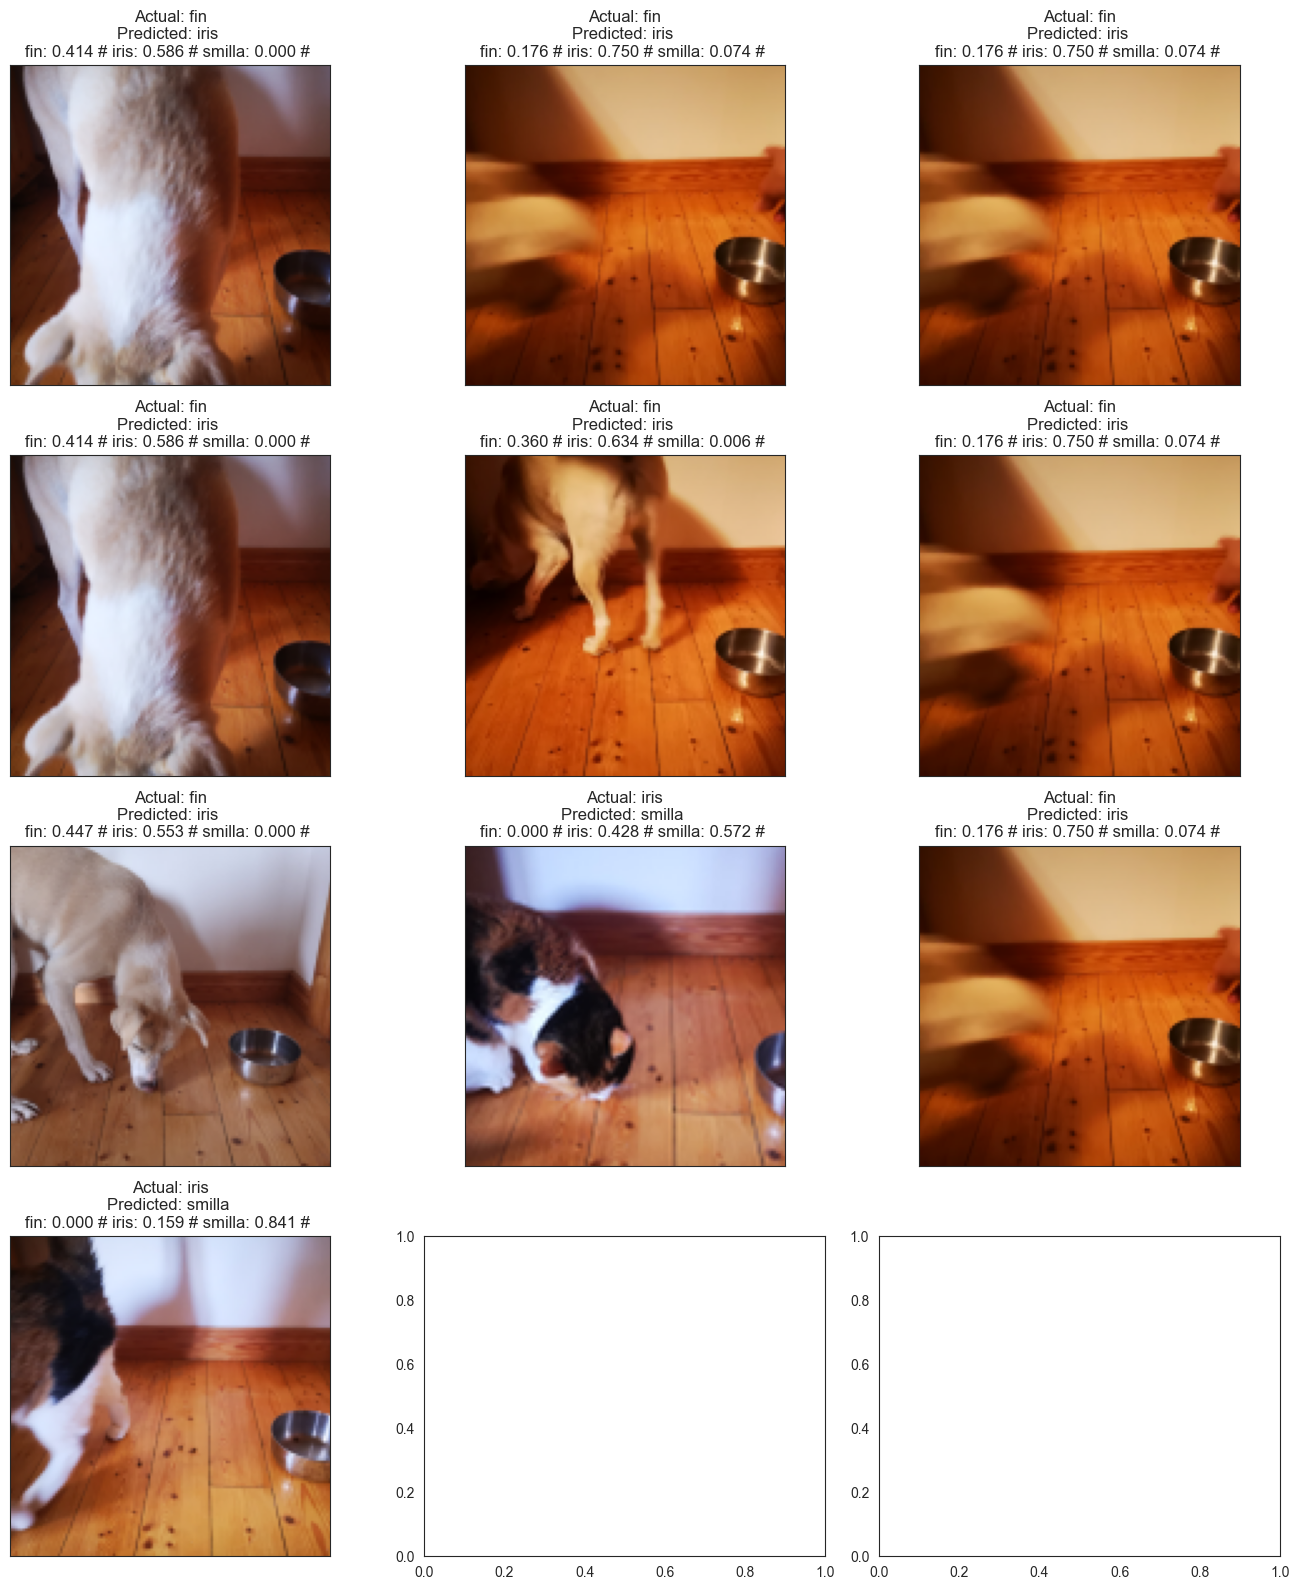

In [230]:

diff = y_true.compare(y_pred)

diff_labels = np.array(diff)
diff_len = len(diff_labels)
nrows = diff_len//3 + (1 if diff_len%3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:diff_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for coord, idx, labs in zip(coords, diff.index, diff_labels):
    title_str = f'Actual: {labs[0]}\nPredicted: {labs[1]} \n'
    for x, lab in label_dict:
        title_str += f'{lab}: {y_pred_raw[idx][x]:.3f} # '
    #title_str += f'{y_pred_raw[idx]*100}'
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
plt.savefig(f'{output_path}/pred_diff_test_montage.png')
plt.show()
    


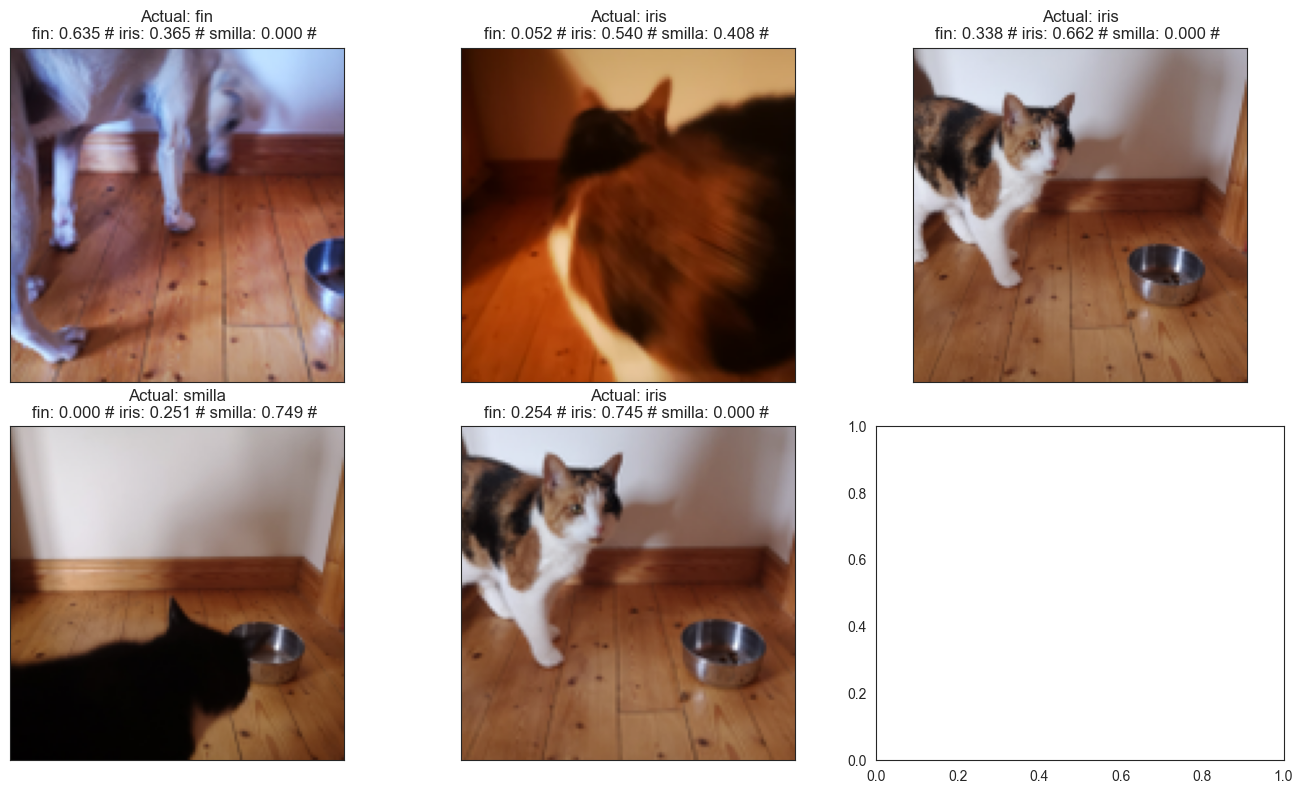

In [231]:

new_pred = y_pred_raw.flatten()
#diff = y_true.compare(y_pred)
unsure_idx = []
unsure_labels = []

new_pred = np.array([1 if x < 0.75 and x > 0.5 else 0 for x in new_pred]).reshape(-1, 3)
new_true = y_true.to_numpy().flatten()

for idx, (el, lab) in enumerate(zip(new_pred, new_true)):
    if 1 in el:
        if idx in diff.index:
            continue
        unsure_idx.append(idx)
        unsure_labels.append(lab)
        
unsure_len = len(unsure_idx)
nrows = unsure_len//3 + (1 if unsure_len%3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:unsure_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*5))
for coord, idx, labs in zip(coords, unsure_idx, unsure_labels):
    title_str = f'Actual: {labs}\n'
    for x, lab in label_dict:
        title_str += f'{lab}: {y_pred_raw[idx][x]:.3f} # '
    #title_str += f'{y_pred_raw[idx]*100}'
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
plt.savefig(f'{output_path}/pred_unsure_test_montage.png')
plt.show()

In [17]:
from PIL import ImageOps

def save_live_data(path, size):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    Xy_dict = {}
    new_shape = (-1, size[0], size[1], 3)
    for label in os.listdir(path):
        img_list = os.listdir(os.path.join(path, label))
        Xy_dict[label] = np.array([], dtype='int')

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            #img = ImageOps.pad(img, size, method=Image.LANCZOS, color='white')
            if img.size != (size):
                img = img.resize(size, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255
                    
            #new_shape = (-1, size[0], size[1], 3)
            X = np.append(X, img_resized) #.reshape(new_shape)
            y = np.append(y, label)
            Xy_dict[label] = np.append(Xy_dict[label], img_resized)

        X = X.reshape(new_shape)
        Xy_dict[label] = Xy_dict[label].reshape(new_shape)

    # Shuffle the resulting set
    zipped_set = list(zip(y, X))
    random.shuffle(zipped_set)
    y_shuffled, X_shuffled = list(map(list, zip(*zipped_set)))
    X = np.array(X_shuffled, dtype='float')
    y = np.array(y_shuffled, dtype='object')
    
    return X, y, Xy_dict

iris


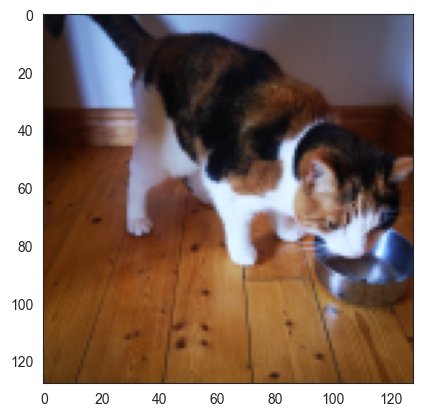

In [18]:
live_path = os.path.join(cwd,'live_img')
X_live, y_live, live_set_by_labels = save_live_data(live_path, size=INPUT_SHAPE[1:3])
print(y_live[4])
plt.imshow(X_live[4])
plt.show()


In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


sns.set_style("white")

y_pred = model.predict(X_live, verbose=3)
label_dict = {0: 'fin', 1: 'iris', 2: 'smilla'}
pred_list = pd.DataFrame(np.array([label_dict[i] for i in np.argmax(y_pred, axis=1)]))
#print(pred_list.compare(pd.DataFrame(y_live)))
#print(pred_list)
y_true = y_live
y_ohe_live = pd.get_dummies(y_live, dtype='int')
#print(X_pred)
X_pred_2 = np.round(y_pred, 2)
df_pred = pd.DataFrame(X_pred_2, columns=LABELS)
#print(df_pred)
#print(df_pred)
#guesses = []
#print(len(X_live))

# for idx, name in label_dict.items():
#     print('\n#####################\nModel believes this is ', name)
#     new_df = df_pred[df_pred[name] > 0.9]
#     for i in new_df.index:
#         #guesses.append(name)
#         print(f'{X_pred[i][idx]*10} %')
#         #print(len(guesses))
        
#         plt.imshow(X_live[i])
#         plt.show()

new_labels = pd.DataFrame(np.array(y_ohe_live), columns=LABELS)
new_labels.insert(column='unknown', loc=len(new_labels.columns), value=0)
#new_labels['unknown'] = 0
#print(new_labels)
y_true = (pd.from_dummies(new_labels))
#print(y_true)
#print(f'labels: {labels}')

    #sample_labels))
#print(labels)
#print(y_pred)

X_pred_1d = y_pred.reshape(-1)
#X_pred = X_pred.round(decimals=0).astype('int')
y_pred = np.array([1 if x > 0.5 else 0 for x in X_pred_1d]).astype('int').reshape(-1, 3) #1 X_pred.round(decimals=0).astype('int')
#print(X_pred)

#print(pd.DataFrame(y_pred, columns=['Fin', 'Iris', 'Smilla']))

y_pred = pd.DataFrame(y_pred, columns=LABELS)
#print(new)
y_pred.insert(column='unknown', loc=len(y_pred.columns), value=y_pred.apply(lambda x: 0 if sum(x.values) > 0 else 1, axis=1))
#print(sum(y_pred['Unknown']))

# Commented out
# if y_pred.any(axis=0)['unknown']:
#     unknown_present = True
#     ix = [f'Actually {label}' for label in LABELS] + ['unknown']
#     cl = [f'Predicted {label}' for label in LABELS] + ['unknown']
#     lb = LABELS + ['unknown']
# else:
ix = [f'Actually {label}' for label in LABELS]
cl = [f'Predicted {label}' for label in LABELS]
lb = LABELS
    
y_pred = pd.from_dummies(y_pred)

c_m = pd.DataFrame(confusion_matrix(y_true, pred_list), index=ix, columns=cl) # removed y_pred
print(c_m)

print(classification_report(y_true, pred_list, target_names=lb)) # removed y_pred

#joblib.dump(((pd.DataFrame(confusion_matrix(y_true, y_pred), index=ix, columns=cl).to_string()), classification_report(y_true, y_pred, target_names=lb)), f'{output_path}/live_class_report.txt')


                 Predicted fin  Predicted iris  Predicted smilla
Actually fin                87               7                 0
Actually iris                1              91                 8
Actually smilla              0               1               133
              precision    recall  f1-score   support

         fin       0.99      0.93      0.96        94
        iris       0.92      0.91      0.91       100
      smilla       0.94      0.99      0.97       134

    accuracy                           0.95       328
   macro avg       0.95      0.94      0.95       328
weighted avg       0.95      0.95      0.95       328



d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


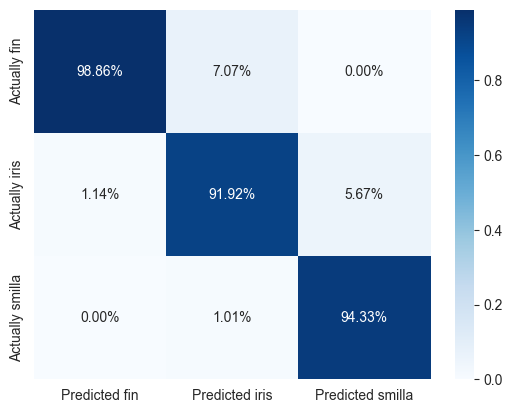

In [38]:
# Showing pred accuracy
c_m = pd.DataFrame(confusion_matrix(y_true, pred_list), index=ix, columns=cl) # removed y_pred
sns.heatmap(c_m/np.sum(c_m), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [39]:

y_labels = {}
y_labels['smilla'] = np.array([0, 0, 1] * len(live_set_by_labels['smilla'])).reshape(-1, 3)
y_labels['iris'] = np.array([0, 1, 0] * len(live_set_by_labels['iris'])).reshape(-1, 3)
y_labels['fin'] = np.array([1, 0, 0] * len(live_set_by_labels['fin'])).reshape(-1, 3)


guessing Counter({'fin': 20}) - actually: fin
Overall confidence:  0.8871481680870058
Overall confidence 2:  0.845


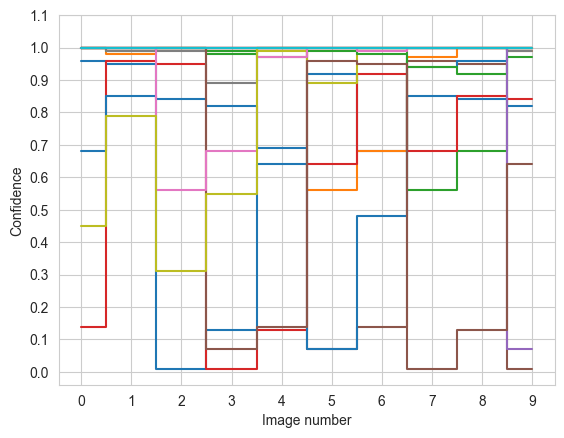

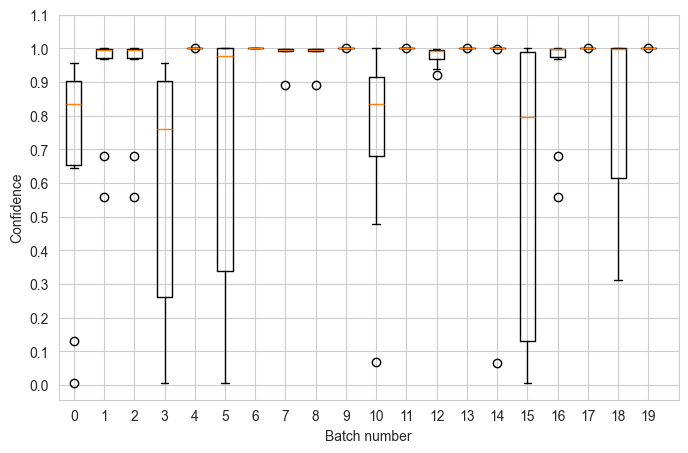

guessing Counter({'fin': 20, 'iris': 20}) - actually: iris
Overall confidence:  0.9207987427711488
Overall confidence 2:  0.915


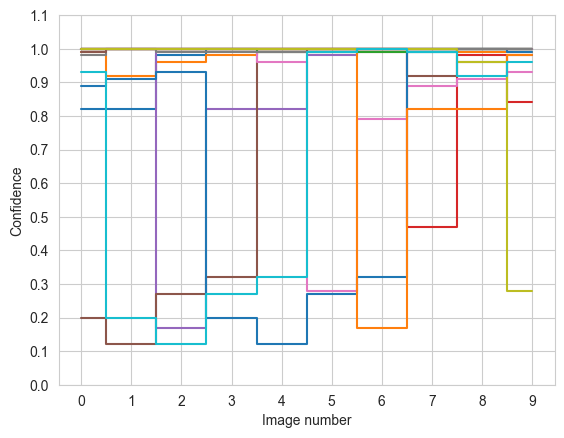

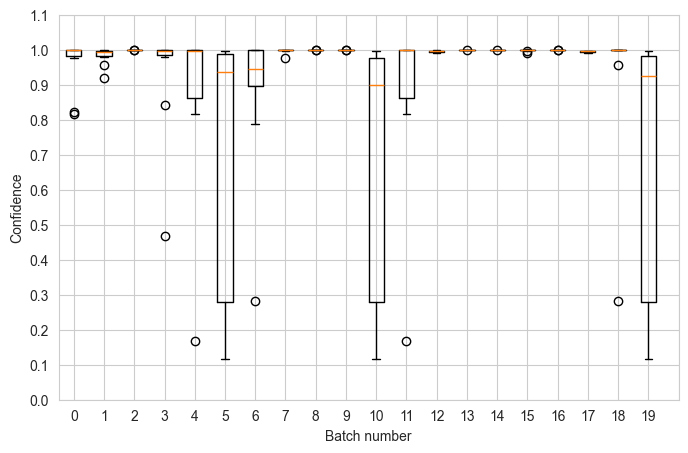

guessing Counter({'fin': 20, 'iris': 20, 'smilla': 20}) - actually: smilla
Overall confidence:  0.9627985739707947
Overall confidence 2:  0.9550000000000001


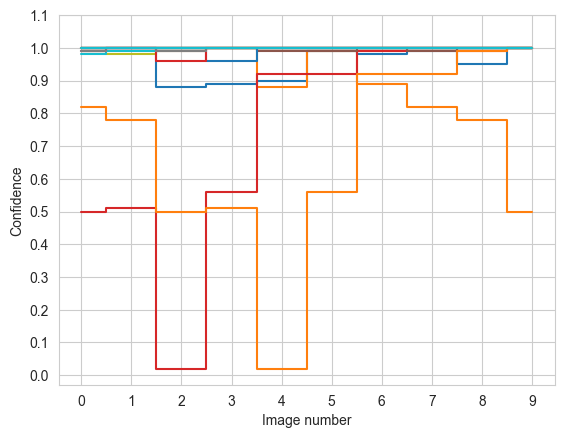

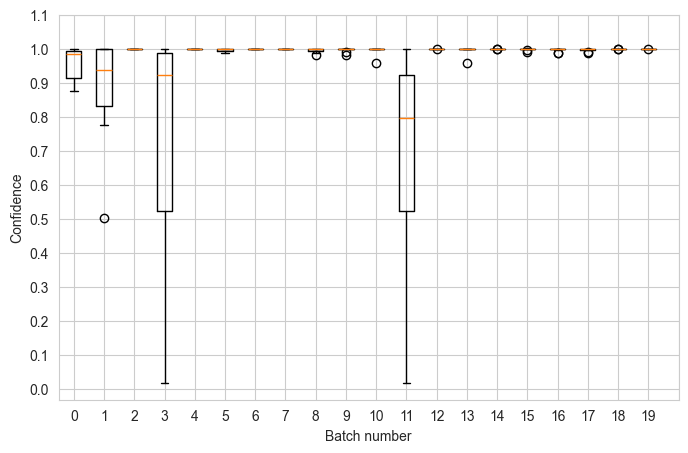

{'true': ['fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla'], 'pred': ['fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'fin', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'iris', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 'smilla', 

In [98]:
# Predict by label batches

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import functools as ft
from collections import Counter

sns.set_style("whitegrid")

#tf.data.experimental.enable_debug_mode()

all_confs = {'true': [], 'pred': []}

for label_name, img_set in live_set_by_labels.items():
    
   # batch_details = {}
    conf_sum = 0
    conf_sum_2 = 0
    
    batch_amount = 20
    sample_amount = 10
    fig, ax = plt.subplots()
    all_means = []
    all_vars = []
    batch_probas = []

    for b_num in range(0, batch_amount):
        img_batch = random.randint(0, len(img_set) - sample_amount)
        start = img_batch
        end = img_batch + sample_amount
        y_ohe_live = y_labels[label_name][start:end]

        y_pred = model.predict(img_set[start:end], verbose=3)
        ### NEW:
        label_dict = {0: 'fin', 1: 'iris', 2: 'smilla'}
        pred_df = pd.DataFrame(np.array([label_dict[i] for i in np.argmax(y_pred, axis=1)]))
        #print(pred_df)
        pred_list = np.array([label_dict[i] for i in np.argmax(y_pred, axis=1)])
        #print(pred_list)
        
        # y_ohe_live = y_labels[key]

        # X_pred = model.predict(value, verbose=3)


        #print(X_pred[:2])
        #print(y_ohe_live[:5])

        X_pred_2 = np.round(y_pred, 2)
        df_pred = pd.DataFrame(X_pred_2, columns=LABELS)

        label_dict = joblib.load(f'{output_path}/class_dict.pkl') #{0: 'Fin', 1: 'Iris', 2: 'Smilla'}

        new_labels = pd.DataFrame(np.array(y_ohe_live), columns=LABELS)
        new_labels['unknown'] = 0
        #print(new_labels)
        y_true = pd.from_dummies(new_labels)
        #print(f'labels: {labels}')

        #print((X_pred[0]))
        #print((X_pred[0][0]))
        # X_pred_2 = np.round(X_pred, 2)
        # df_pred = pd.DataFrame(X_pred_2, columns=['Fin', 'Iris', 'Smilla'])
        #batch_details[batch_idx] = 
        #print(np.array(df_pred[label_name]))
        ax.step(x=range(0, sample_amount), y=df_pred[label_name], where='mid')
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Image number')
        
        #df_pred[label_name].plot(kind='line', marker='^')
        
        result_nums = pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        #print(X_pred)
        #print(result_nums)
        result_value = result_nums.max()
        result_idx = result_nums.idxmax()
        
        # Needed for the boxplot
        batch_probas.append(pd.DataFrame(y_pred)[result_idx].to_numpy())
        
        # calculate mean and variance of each y_pred column
        # do this instead of reduce
        means = (np.mean(np.around(y_pred, 3), axis=0))[result_idx] # pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        # all_means.append(means)
        # vars = (np.std(np.around(y_pred, 3), axis=0))[result_idx] # pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        # # print(vars)
        # all_vars.append(vars)
        
        
        
        X_pred_1d = y_pred.reshape(-1)
        y_pred = np.array([1 if x > 0.75 else 0 for x in X_pred_1d]).astype('int').reshape(-1, 3) #1 X_pred.round(decimals=0).astype('int')
        #print(y_pred)
        result_nums_2 = pd.Series(ft.reduce(lambda a, b: a+b, y_pred))
        result_value_2 = result_nums_2.max()
        confidence_2 = result_value_2/len(y_ohe_live)
        result_idx_2 = result_nums_2.idxmax()
        
        #print('conf2: ', confidence_2)
        #print('pet2: ', label_dict[result_idx_2])
        
        confidence = result_value/len(y_ohe_live)
        pet_guess = label_dict[result_idx]
        #print(f'{confidence} - guessing {pet_guess} - actually: {label_name}')
        
        pet_pred = sorted(Counter(pred_list).items(), key=lambda x: x[1], reverse=True)[0][0]
        #print(f'{pet_pred} with argmax')
        
        #print(sorted(Counter(pred_list), key=lambda x: x[1] for x in x.items))
        all_confs['true'].append(label_name)
        #all_confs['pred'].append(pet_guess)
        all_confs['pred'].append(pet_pred)
        
        conf_sum += confidence
        conf_sum_2 += confidence_2

        y_pred = pd.DataFrame(y_pred, columns=LABELS)
        #new_preds[new_preds.sum(axis=1) > 1] = [0, 0, 1]
        #print(new)
        y_pred['unknown'] = y_pred.apply(lambda x: 0 if sum(x.values) > 0 else 1, axis=1)
        # #print(new_preds)

        y_pred = pd.from_dummies(y_pred)
        # #print(y_p)
        #diff = y_true.compare(y_pred)
#        print('diff confidence:')
#        print(len(np.array(diff))/batch_amount)
            
    print(f'guessing {Counter(all_confs['pred'])} - actually: {label_name}')
    print('Overall confidence: ', conf_sum / batch_amount)
    print('Overall confidence 2: ', conf_sum_2 / batch_amount)
    
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(0, sample_amount, 1))
    plt.show()
    
    # plt.errorbar(range(0, len(all_means)), all_means, all_vars, linestyle='None', marker='^')
    # plt.yticks(np.arange(0, 1.2, 0.1))
    # plt.xticks(np.arange(0, batch_amount, 1))
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    for c, x in enumerate(batch_probas):
        ax.boxplot(x, positions=[c], widths=0.5)
        ax.set_ylabel('Confidence')
        ax.set_xlabel('Batch number')
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(0, batch_amount+1, 1))
    plt.show()

    
print(all_confs)

ix = [f'Actually {label}' for label in LABELS]
cl = [f'Predicted {label}' for label in LABELS]
lb = LABELS
    
print(pd.DataFrame(confusion_matrix(all_confs['true'], all_confs['pred']), index=ix, columns=cl)) #, index=ix, columns=cl))
print(classification_report(all_confs['true'], all_confs['pred'], target_names=lb))


In [97]:

diff = y_true.compare(y_pred)

for i in diff.index:
    print(f'actual: {y_pred[i]}')
    print(f'predicted: Fin: {float(X_pred_2[i][0])*100} %, Iris: {float(X_pred_2[i][1])*100} %, Smilla: {float(X_pred_2[i][2])*100}%')
    plt.imshow(X_live[i])
    plt.show()